### 0. Importación de librerías y carga de datos

In [1]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# q-q plots
import scipy.stats as stats

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

In [2]:
# Se cargan los datos
# Ubicación de los datos, deben estar en la misma carpeta que este notebook

#pais, liga = "belgica", "jupiler-pro-league"
#pais, liga = "espana", "laliga"
#pais, liga = "espana", "laliga-smartbank"
#pais, liga = "francia", "ligue-1"
#pais, liga = "francia", "ligue-2"
#pais, liga = "inglaterra", "championship"
#pais, liga = "inglaterra", "premier-league"
#pais, liga = "italia", "serie-a"
#pais, liga = "italia", "serie-b"
#pais, liga = "paises-bajos", "eredivisie"
#pais, liga = "portugal", "liga-portugal"
pais, liga = "turquia", "super-lig"

version = 0

db_location = f"data/{pais}_{liga}/version{version}/resultados_anteriores.csv"

# Se leen los datos, estan separados con ','
data = pd.read_csv(db_location, sep=',', encoding = 'utf-8', na_values = '-')

### 1. Entendimiento de los datos

In [3]:
# Se revisa la forma general de los datos cargados
data.shape

(214, 42)

In [4]:
# Se muestra una pequeña muestra de los datos
data.head()

,Date,HomeTeam,AwayTeam,HG,AG,HP,AP,HTS,ATS,HSI,...,ATP,HPC,APC,HT,AT,HA,AA,HDA,ADA,Resultado
0,06.03.2023 12:00,Kasimpasa,Antalyaspor,3,1,35%,65%,10,15,4,...,577,234,501,19,13,100,142,68,109,2
1,05.03.2023 11:00,Beşiktaş,Ankaragucu,2,1,51%,49%,20,10,10,...,421,370,332,14,23,110,84,69,63,1
2,05.03.2023 08:00,Konyaspor,Giresunspor,0,0,65%,35%,18,6,6,...,315,512,233,13,13,109,73,77,25,0
3,04.03.2023 11:00,Kayserispor,Fenerbahçe,1,2,41%,59%,15,17,3,...,505,237,419,16,17,92,96,77,88,-1
4,04.03.2023 08:00,Trabzonspor,Umraniyespor,1,2,68%,32%,25,12,7,...,309,546,204,8,28,150,85,124,36,-1


In [5]:
# Se imprimen los diferentes tipos de las columnas. Todas son numéricas
#data.dtypes

In [6]:
# Se hace una decripción de los datos
#data.describe()

In [7]:
# Se observa que no existen valores nulos en las variables
#data.isnull().sum()

### 2. Identificación de variables a utilizar

In [8]:
# Se revisa si la variable objetivo está correlacionada con otra variable
#plt.figure(figsize =(30,30))
#correlacion = data.corr()
#sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

In [9]:
# Se diagrama la relación entre cada variable explicativa y la variable objetivo
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[0:4], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[4:10], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[8:12], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[12:16], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[16:20], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[20:24], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[24:28], kind='scatter')
#sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[28:32], kind='scatter')

In [10]:
selected_cols = ['HTS', 'ATS', 'HSI', 'ASI', 'HSO', 'ASO', 'HBS', 'ABS', 'HGS', 'AGS']
selected_cols2 = ['HP', 'AP', 'HC', 'AC', 'HOFF', 'AOFF', 'HF', 'AF',
                    'HYC', 'AYC', 'HTP', 'ATP', 'HT', 'AT', 'HA', 'AA', 'HDA', 'ADA']

### 3. Limpieza y preparación de datos

In [11]:
# los pasos de limpieza y preparación se realizan sobre otro archivo
df_data = data.copy()[selected_cols]
df_data.insert(0, "Resultado", data["Resultado"])

In [12]:
df_data.head()

,Resultado,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,HGS,AGS
0,2,10,15,4,2,4,5,2,8,1,1
1,1,20,10,10,4,8,4,2,2,3,8
2,0,18,6,6,1,7,4,5,1,1,6
3,-1,15,17,3,4,7,7,5,6,2,2
4,-1,25,12,7,7,12,5,6,0,5,6


In [13]:
#def convert_possession(value):
#    value2 = str(value)  # cast to string
#    value3 = value2[:-1] # last four characters
#    return int(value3) if len(value3) > 0 else 50

#df_data['HP'] = df_data['HP'].apply(convert_possession)
#df_data['AP'] = df_data['AP'].apply(convert_possession)

In [14]:
#def convert_yellow_cards(value):
#    return int(value)

#df_data['HYC'] = df_data['HYC'].fillna(0)
#df_data['AYC'] = df_data['AYC'].fillna(0)
#df_data['HYC'] = df_data['HYC'].apply(convert_yellow_cards)
#df_data['AYC'] = df_data['AYC'].apply(convert_yellow_cards)

In [15]:
df_data.head()

,Resultado,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,HGS,AGS
0,2,10,15,4,2,4,5,2,8,1,1
1,1,20,10,10,4,8,4,2,2,3,8
2,0,18,6,6,1,7,4,5,1,1,6
3,-1,15,17,3,4,7,7,5,6,2,2
4,-1,25,12,7,7,12,5,6,0,5,6


### 4. Modelamiento

#### Pipeline 1: solo con selección de variables

In [16]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]
# Se declara el modelo
model = [('model', LinearRegression())]
# Se declara el pipeline
pipeline1 = Pipeline(pre+model)

In [17]:
# Se extraen las variables explicativas y objetivo para entrenar
df_datap1 = df_data

X = df_datap1.drop('Resultado', axis = 1)
Y = df_datap1['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline1 = pipeline1.fit(X_train,Y_train)

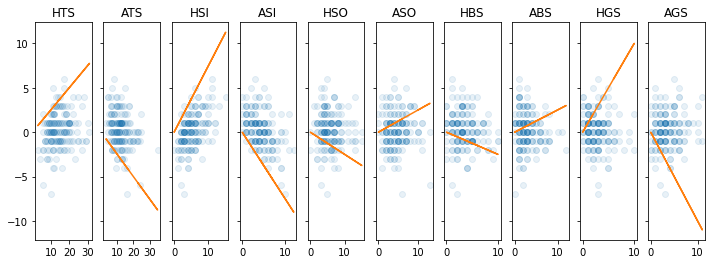

In [18]:
# Se visualiza la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):
    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X_train[col]
    # Pendiente
    m = pipeline1['model'].coef_[pos_col]
    # Interceto
    b = pipeline1['model'].intercept_

    axs[i].plot(x, Y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

In [19]:
# Vale la pena hacer estandarización de los datos para tener coeficientes más comparables en misma escala.
importancia = pipeline1['model'].coef_
pd.options.display.float_format = '{:.5f}'.format
importancia_atributo = pd.DataFrame(data={"Atributo": selected_cols,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,HGS,1.00000
1,HSI,0.75000
2,ABS,0.25000
3,HTS,0.25000
4,ASO,0.25000
5,HBS,-0.25000
6,HSO,-0.25000
7,ATS,-0.25000
8,ASI,-0.75000
9,AGS,-1.00000


In [20]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline1.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #1 - Datos de entrenamiento
RMSE: 0.00
R²: 1.00


In [21]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline1.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #1 - Datos de test
RMSE: 0.00
R²: 1.00


In [22]:
# Se revisa la colinealidad
#df_temp = df_datap1[selected_cols]
#plt.figure(figsize =(30,30))
#correlacion = df_datap1.corr()
#sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

In [23]:
# Linealidad
#Se ven datos relativamente juntos, sin embargo, hay una pequeña cantidad de datos fuera de esta cohesión en las tres variables.
#sns.pairplot(df_datap1, height=3, aspect = 0.6, y_vars = 'Resultado', x_vars = selected_cols, kind='scatter', plot_kws = {'alpha':0.1})

In [24]:
# Nos sirve para revisar si los errores vienen con una distribución teoríca. En este caso, de una distribución normal.
X = df_data.drop('Resultado', axis = 1)
y = df_data['Resultado']

# Calculamos los errores
#errors = (pipeline1.predict(X) - y).values

#fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
#sns.scatterplot(x = pipeline1.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
#_ = stats.probplot(errors, dist="norm", plot=axes[1])

In [25]:
# Diagrama de caja
# Acá podemos ver los valores atípicos de Life expectancy.
# En este caso están los menores a 44.5.
#fig=plt.figure(figsize=(15,5))
#ax = sns.boxplot(data= df_datap1[['Resultado']], orient="h")

#### Pipeline 2: Modelo con eliminación de valores atípicos en la variable objetivo y estandarización

In [26]:
# Se eliminan los valores atípicos que indica el diagrama de caja.
df_datap2 = df_data
#df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] <= -2].index)
#df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] > 2].index)

In [27]:
# Se declara el modelo
model2 = [('model2', LinearRegression())]

#Pre
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('scaler', StandardScaler()),]

# Se declara el pipeline
pipeline2 = Pipeline(pre+model2)

# Se extraen las variables explicativas y objetivo para entrenar
X = df_datap2.drop('Resultado', axis = 1)
Y = df_datap2['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline2 = pipeline2.fit(X_train,Y_train)

In [28]:
# Se calculan los errores
#errors = (pipeline2.predict(X_train) - Y_train).values

#fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
#sns.scatterplot(x = pipeline2.predict(X_train), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
#_ = stats.probplot(errors, dist="norm", plot=axes[1])

In [29]:
# Diagrama de caja
# Se ve que los datos ya están eliminados
#fig=plt.figure(figsize=(15,5))
#ax = sns.boxplot(data= df_datap2[['Resultado']], orient="h")

In [30]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline2.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #2 - Datos de entrenamiento
RMSE: 0.00
R²: 1.00


In [31]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline2.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #2 - Datos de test
RMSE: 0.00
R²: 1.00


### 5. Evaluación cuantitativa

In [32]:
# Se ajusta el modelo para ver el reporte de estadísticas
#model = sm.OLS(Y, X).fit()
# Se muestran las estadísticas del modelo
#model.summary()

In [33]:
# Se guarda el pipeline en el archivo
filename = 'model/modelo.joblib' # Ubicación del archivo a entregar
dump(pipeline2, filename)

['model/modelo.joblib']

In [34]:
# Proceso de prueba del cliente
df_recent = pd.read_csv(f"data/{pais}_{liga}/version{version}/proximos_partidos.csv", sep=',', encoding = 'utf-8', na_values = '-') # Lectura de los datos recientes

# Se lee el archivo y carga el modelo
pipeline = load(filename)

y_predicted = pipeline.predict(df_recent)

In [35]:
for i in y_predicted[:29]:
    print ("{:.2f}".format(i).replace('.', ','))

0,23
1,05
3,08
-1,36
-0,92
1,55
-2,53
-3,10
-1,84
4,44
1,08
2,09
-0,82
0,32
-1,36
3,98
0,43
0,14
-0,97
1,38
0,57
-1,58
1,82
1,18
0,07
-2,20
1,72
1,00
2,70


In [36]:
for i in range(len(y_predicted[:29])):
    home_team = df_recent.iloc[i]["HomeTeam"]
    away_team = df_recent.iloc[i]["AwayTeam"]
    
    print(home_team + " vs " + away_team)
    print(y_predicted[i])
    ganador = home_team if y_predicted[i] >= 0.5 else (away_team if y_predicted[i] <= -0.5 else "ninguno")
    if ganador == "ninguno":
            print("No hay ganador claro. " + str(abs(y_predicted[i]))[:4])
    else:
        print("Gana " + ganador + " por " + str(abs(y_predicted[i]))[:4] + " goles")
    print()

Giresunspor vs Karagumruk
0.22727272727272715
No hay ganador claro. 0.22

Antalyaspor vs Kayserispor
1.0454545454545447
Gana Antalyaspor por 1.04 goles

Galatasaray vs Kasimpasa
3.0818181818181816
Gana Galatasaray por 3.08 goles

Ankaragucu vs Alanyaspor
-1.3636363636363646
Gana Alanyaspor por 1.36 goles

Trabzonspor vs Adana Demirspor
-0.916666666666667
Gana Adana Demirspor por 0.91 goles

Başakşehir vs Beşiktaş
1.5454545454545454
Gana Başakşehir por 1.54 goles

Istanbulspor vs Sivasspor
-2.533333333333334
Gana Sivasspor por 2.53 goles

Konyaspor vs Galatasaray
-3.0984848484848455
Gana Galatasaray por 3.09 goles

Kasimpasa vs Umraniyespor
-1.8391608391608387
Gana Umraniyespor por 1.83 goles

Adana Demirspor vs Antalyaspor
4.4363636363636365
Gana Adana Demirspor por 4.43 goles

Beşiktaş vs Istanbulspor
1.083333333333334
Gana Beşiktaş por 1.08 goles

Karagumruk vs Başakşehir
2.0909090909090913
Gana Karagumruk por 2.09 goles

Sivasspor vs Ankaragucu
-0.8181818181818175
Gana Ankaragucu po